# Training conditional GANs (cGANs): Pix2Pix

## Resources 


In [78]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os


## Datasets



Download a dataset, e.g.:

-   Standard pix2pix datasets: [http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/)
-   Comic faces: [https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic](https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic)
-   Maps: [https://www.kaggle.com/datasets/alincijov/pix2pix-maps](https://www.kaggle.com/datasets/alincijov/pix2pix-maps)
-   Rembrandt: [https://www.kaggle.com/datasets/grafstor/rembrandt-pix2pix-dataset](https://www.kaggle.com/datasets/grafstor/rembrandt-pix2pix-dataset)
-   Depth [https://www.kaggle.com/datasets/greg115/pix2pix-depth](https://www.kaggle.com/datasets/greg115/pix2pix-depth)

Or create your own using the notebook.



## Load and preprocess dataset



Let&rsquo;s first specify the path of our dataset and the desired image size (do not change the latter):



In [79]:
dataset_path = "./datasets/edge2comics/" # Change this for your custom dataset
img_channels = 3
img_size = 256
batch_size = 1
val_size = 0.2
target_index = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Can try 'mps' if using mac

Each training image in a standard pix2pix dataset consists of one imgage divided into two adjacent **source** and **target** images.
The layout of the source and target may vary from training set to trainig set, so we provide a `target_index` flag the determines on which side the target is (`0` if on the left and `1` if on the right). Set this so the examples from the dataset appear with the source image to the left.

The following code also **augments** the dataset by applying random uniform scaling (by upscaling and cropping) and random mirroring to the input output pairs. This should lead to a more stable model according to the original pix2pix paper. Finally the images ar normalized to the [-1,1] range as required by our GAN-based model.

We will organize the dataset in batches of size `1`, as that is generally suggested for pix2pix models. That means that we will update the weights of the model for each image pair separately.

Run the code below and examine the resulting example images. Then set the `target_index` variable to reflect the position of the target image. That is `target_index=0` if the target image is on the left and `target_index=1` if it is on the right.



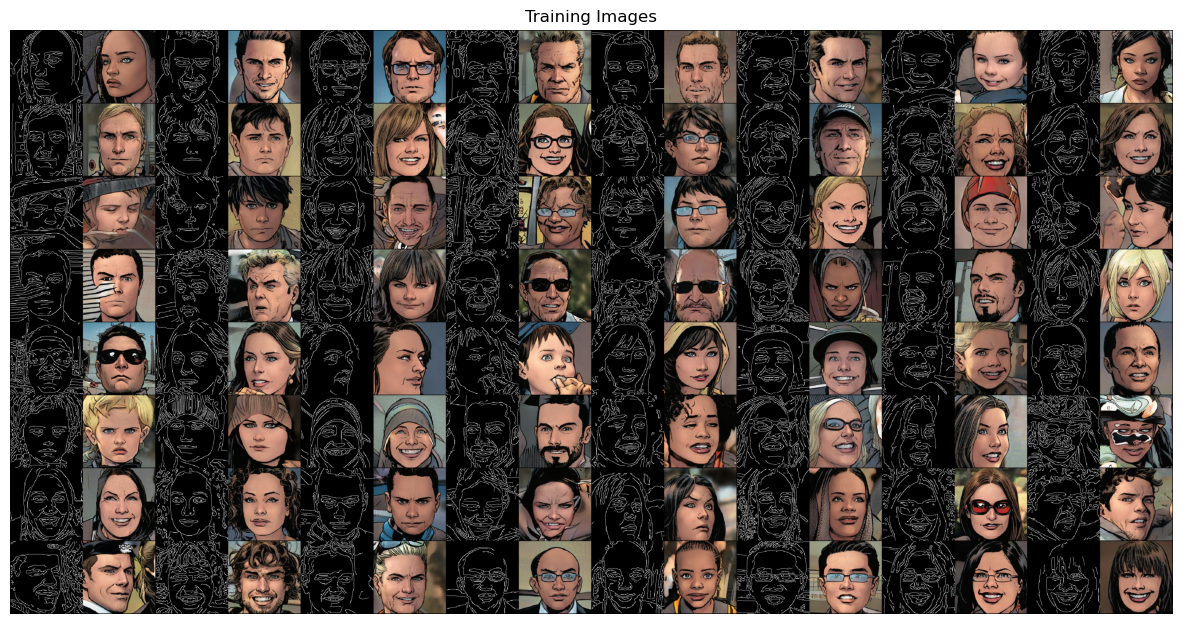

In [80]:
def preprocess_image(input_image, target_image):
    # Random jitter
    input_image, target_image = random_jitter(input_image, target_image)

    # Normalize
    input_image = transforms.functional.normalize(input_image, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    target_image = transforms.functional.normalize(target_image, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    return input_image, target_image

def random_jitter(input_image, target_image):
    # Resizing to 286x286
    resize_transform = transforms.Resize(size=(286, 286), interpolation=transforms.InterpolationMode.NEAREST)
    input_image = resize_transform(input_image)
    target_image = resize_transform(target_image)

    # Random cropping back to 256x256
    i, j, h, w = transforms.RandomCrop.get_params(input_image, output_size=(256, 256))
    input_image = transforms.functional.crop(input_image, i, j, h, w)
    target_image = transforms.functional.crop(target_image, i, j, h, w)

    # Random mirroring
    if np.random.uniform() < 0.5:
        input_image = transforms.functional.hflip(input_image)
        target_image = transforms.functional.hflip(target_image)

    return input_image, target_image

class Pix2PixImageDataset(Dataset):
    def __init__(self, path, target_index):
        super(Pix2PixImageDataset, self).__init__()
        self.files = [os.path.join(path, f) for f in os.listdir(path) if '.jpg' in f or '.png' in f]
        self.target_index = target_index
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        image = Image.open(path)
        image = torchvision.transforms.ToTensor()(image)
        w = image.shape[-1]
        w = w // 2

        if target_index == 0:
            input_image = image[:, :, w:]
            target_image = image[:, :, :w]
        else:
            target_image = image[:, :, w:]
            input_image = image[:, :, :w]
        # Jitter
        input_image, target_image = random_jitter(input_image, target_image)
        # Normalize
        input_image = input_image*2 - 1
        target_image = target_image*2 - 1
        return input_image, target_image


train_dataset = Pix2PixImageDataset(dataset_path, target_index)
val_dataset = Pix2PixImageDataset(dataset_path, target_index)

# get length of the full dataset before split, and save it in idx
num_train = len(train_dataset)

# create an array of idx numbers for each element of the full dataset
idx = list(range(num_train))
#print(num_train, idx)

# perform train / val split for data points
train_indices, val_indices = train_test_split(idx, test_size=val_size, random_state=42)

# override datasets to only be samples for each split
train_dataset = Subset(train_dataset, train_indices)
val_dataset = Subset(val_dataset, val_indices)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# get a batch of training images
sample_batch = [torch.cat(image_pair, axis=-1)[0] for image_pair in list(train_loader)[:64]]

# create a grid of images
img_grid = vutils.make_grid(sample_batch, padding=2, normalize=True)

# convert to NumPy and transpose dimensions for matplotlib
img_grid_np = np.transpose(img_grid.cpu().numpy(), (1, 2, 0))

# plot the grid of images
plt.figure(figsize=(15, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(img_grid_np)
plt.show()


## Build  the model



The pix2pix model is a conditional generative adversarial network (cGAN). A CGAN
is a type of GAN model used for generating new data samples with specific
attributes or characteristics. In a CGAN, both the generator and discriminator
are *conditioned* on additional information, such as class labels, tags, or
other types of metadata. The generator network takes in random noise as well as
the conditional information as input and produces a new data sample that matches
the desired attributes. The discriminator network, on the other hand, tries to
distinguish between the generated samples and real samples based on both their
visual appearance and the conditional information. For the case of a pix2pix
model the network is conditioned on an image, which should be transformed into
an output image.



### Generator



Differently from a DC-GAN, the generator of the pix2pix model is based on the
[U-net](https://arxiv.org/abs/1505.04597) architecture. A U-net model is a CNN architecture that is typically used
for image segmentation tasks. The name U-net derives from the architecture,
which resembles the letter &ldquo;U&rdquo;. It consists of two main parts: an *encoder* and
a *decoder*. The encoder part consists of a series of convolutional layers,
which reduce the spatial dimensionality of the input image while increasing its
depth. This is followed by a bottleneck layer that extracts the most important
features from the input image. The decoder part is a &ldquo;mirror image&rdquo; of the
encoder. It consists of a series of layers that gradually increase the spatial
dimensionality of the output, while decreasing its depth. This is similar to
what we have seen in the DC-GAN example, but here we use a &ldquo;transposed
convolution&rdquo; layer (`Conv2DTranspose`), while in the DCGAN example we used an
upscaling followed by a convolution. The output of each layer in the encoder is
also concatenated with the output of another layer in the decoder. This creates
&ldquo;skip connections&rdquo; that help preserve spatial information and avoid information
loss during the encoding and decoding process.



In [88]:
import torch
import torch.nn as nn

import torch.nn as nn
import torch.nn.functional as F

class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, size, apply_batchnorm=True):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, size, stride=2, padding=1, bias=not apply_batchnorm)
        self.batchnorm = nn.BatchNorm2d(out_channels) if apply_batchnorm else None
        self.leakyrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.batchnorm(x)
        x = self.leakyrelu(x)
        return x

class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, size, apply_dropout=False):
        super(Upsample, self).__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, size, stride=2, padding=1, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.5) if apply_dropout else None
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv_transpose(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = self.dropout(x)
        x = self.relu(x)
        return x

class Generator(nn.Module):
    def __init__(self, img_channels=3):
        super(Generator, self).__init__()

        self.down_stack = [
            Downsample(3, 64, 4, apply_batchnorm=False),
            Downsample(64, 128, 4),
            Downsample(128, 256, 4),
            Downsample(256, 512, 4),
            Downsample(512, 512, 4),
            Downsample(512, 512, 4),
            Downsample(512, 512, 4),
            Downsample(512, 512, 4, apply_batchnorm=False)
        ]

        self.up_stack = [
            Upsample(512, 512, 4, apply_dropout=True),
            Upsample(1024, 512, 4, apply_dropout=True),
            Upsample(1024, 512, 4, apply_dropout=True),
            Upsample(1024, 512, 4),
            Upsample(1024, 256, 4),
            Upsample(512, 128, 4),
            Upsample(256, 64, 4)
        ]

        self.last = nn.ConvTranspose2d(128, img_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        skips = []
        for i, down in enumerate(self.down_stack):
            x = down(x)
            skips.append(x)
        
        skips = list(reversed(skips[:-1]))

        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)
        
        x = self.last(x)
        return torch.tanh(x)

class DownSample(nn.Module):
    def __init__(self, in_size, out_size, k_size=4, apply_batchnorm=True):
        super(DownSample, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, kernel_size=k_size, stride=2, padding=(1,1), bias=False)]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.3, True))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UpSample(nn.Module):
    def __init__(self, in_size, out_size, k_size=4, dropout=False):
        super(UpSample, self).__init__()
        layers = [nn.ConvTranspose2d(in_size, out_size, kernel_size=k_size, stride=2, padding=(1,1), bias=False)        ]
        layers.append(nn.BatchNorm2d(out_size))
        if dropout:
            layers.append(nn.Dropout(dropout))
        layers.append(nn.ReLU(True))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x


class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        self.down1 = DownSample(in_channels, 64, apply_batchnorm=False)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)
        self.down5 = DownSample(512, 512)
        self.down6 = DownSample(512, 512)
        self.down7 = DownSample(512, 512)
        self.down8 = DownSample(512, 512, apply_batchnorm=False)

        self.up1 = UpSample(512, 512, dropout=0.5)
        self.up2 = UpSample(1024, 512, dropout=0.5)
        self.up3 = UpSample(1024, 512, dropout=0.5)
        self.up4 = UpSample(1024, 512)
        self.up5 = UpSample(1024, 256)
        self.up6 = UpSample(512, 128)
        self.up7 = UpSample(256, 64)

        self.final = nn.Sequential(
            # nn.Upsample(scale_factor=2),
            # nn.ZeroPad2d((1, 0, 1, 0)),
            nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=(1,1), bias=True),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        return self.final(u7)

generator = Generator()
print(generator)

Generator(
  (down1): DownSample(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.3, inplace=True)
    )
  )
  (down2): DownSample(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.3, inplace=True)
    )
  )
  (down3): DownSample(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.3, inplace=True)
    )
  )
  (down4): DownSample(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affin

### Discriminator



The discriminator in the pix2pix model is a convolutional &ldquo;PatchGAN classifier&rdquo;.
It tries to classify if each **image patch** if it is real or not real. In the
following decoder, each 30 x 30 image patch of the output classifies a 70 x 70
portion of the input image.



In [87]:
class Discriminator(nn.Module):
    def __init__(self, image_channels=3):
        super(Discriminator, self).__init__()
        self.down1 = Downsample(image_channels*2, 64, 4, apply_batchnorm=False)
        self.down2 = Downsample(64, 128, 4)
        self.down3 = Downsample(128, 256, 4)
        self.zero_pad1 = nn.ZeroPad2d(1)
        self.conv = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(512)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.zero_pad2 = nn.ZeroPad2d(1)
        self.last = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0)

    def forward(self, inp, tar):
        x = torch.cat([inp, tar], dim=1)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.batchnorm1(x)
        x = self.leakyrelu(x)
        x = self.zero_pad2(x)
        x = self.last(x)
        return x

##############################
#        Discriminator       #
##############################

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            DownSample(in_channels*2, 64, apply_batchnorm=False),
            DownSample(64, 128 ),
            DownSample(128, 256 ),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=(1,1), bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.3, True),
            
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=(1,1),bias=True)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)



discriminator = Discriminator()
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): DownSample(
      (model): Sequential(
        (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.3, inplace=True)
      )
    )
    (1): DownSample(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.3, inplace=True)
      )
    )
    (2): DownSample(
      (model): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.3, inplace=True)
      )
    )
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, af

### Generate some images before training



Let&rsquo;s generate some images before training to see what the network will output



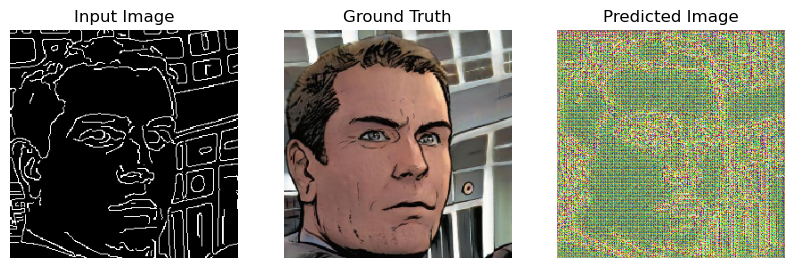

In [83]:
def numpy_image(x):
    return np.transpose(x.detach().cpu().numpy(), (1, 2, 0))*0.5 + 0.5

def generate_images(model, test_input, tar, fname=''):
    prediction = model(test_input) #, training=True)
    plt.figure(figsize=(10, 10))

    if tar is not None:
        display_list = [test_input[0], tar[0], prediction[0]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
    else:
        display_list = [test_input[0], prediction[0]]
        title = ['Input Image', 'Predicted Image']

    for i in range(len(title)):
        plt.subplot(1, len(title), i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(numpy_image(display_list[i]))
        plt.axis('off')

    if fname:
        plt.savefig(fname)
        plt.close()
    else:
        plt.show()

for example_input, example_target in list(train_loader)[:3]:
    generate_images(generator, example_input, example_target)
    break


## Training the model



### Generator loss



GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

-   The generator loss is a sigmoid cross-entropy loss of the generated images and an array of ones.
-   The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
-   This allows the generated image to become structurally similar to the target image.
-   The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

Feel free to experiment with modifying the value of `LAMBDA` (if you have time to spare:))



In [84]:

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    real_class = torch.ones_like(disc_generated_output).to(device)
    
    # Binary cross entropy loss
    gan_loss = F.binary_cross_entropy_with_logits(disc_generated_output, real_class)

    # Mean absolute error
    l1_loss = F.l1_loss(gen_output, target)

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

### Discriminator loss



The discriminator<sub>loss</sub> function takes 2 inputs: real images and generated images.

-   The `real_loss` is a sigmoid cross-entropy loss of the real images and an array of ones (since these are the real images).
-   The `generated_loss` is a sigmoid cross-entropy loss of the generated images and an array of zeros (since these are the fake images).
-   The `total_loss` is simply the sum of `real_loss` and `generated_loss`.



In [85]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_class = torch.ones_like(disc_generated_output).to(device)
    fake_class = torch.ones_like(disc_generated_output).to(device)
    
    # Binary cross entropy loss for real images
    real_loss = F.binary_cross_entropy_with_logits(disc_real_output, real_class)
    # Binary cross entropy loss for generated images
    generated_loss = F.binary_cross_entropy_with_logits(disc_generated_output, fake_class)
    # Total discriminator loss
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss


### Training loop



The training loop procedes as follows:

-   For each example input we generate an output.
-   The discriminator receives the input image and the generated image as the first input. The second input is the input image and the target image.
-   Next, calculate the generator and the discriminator loss.
-   Then, calculate the gradients of the loss with respect to both the generator and the discriminator variables (inputs) and apply those to the optimizer.



In [89]:
import os
import sys
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt

epochs = 100
LAMBDA = 100 # Weight of L1 loss in optimization 
save_interval = 1

model_path = "./models/edges2comics"
os.makedirs(model_path, exist_ok=True)

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

def train_step(input_image, target_image):
    # Generate output
    gen_output = generator(input_image) 

    # ---- Update discriminator ----
    disc_optimizer.zero_grad() # Clear gradients

    # Classify real and fake patches 
    # Here we "freeze" generator gradients since we only optimize the discriminator
    # 
    real_patch = discriminator(input_image, target_image)
    fake_patch = discriminator(input_image, gen_output.detach()) 

    # Compute loss for real/fake patches
    # log(D(x,y)) + log(1 - D(x,G(x)))
    real_class = torch.ones_like(real_patch).to(device)
    fake_class = torch.zeros_like(fake_patch).to(device)

    real_loss = F.binary_cross_entropy_with_logits(real_patch, real_class)
    fake_loss = F.binary_cross_entropy_with_logits(fake_patch, fake_class)
    disc_loss = real_loss + fake_loss

    # Propagate gradients and perform gradient descent step
    disc_loss.backward()
    disc_optimizer.step()

    # ---- Update generator ---- 
    gen_optimizer.zero_grad() # Clear gradients
    # Classify fake samples, now considering generator gradients
    fake_patch = discriminator(input_image, gen_output)
    # Compute loss according to paper 
    # log(D(x,G(x))) + L1(y,G(x))
    fake_gan_loss = F.binary_cross_entropy_with_logits(fake_patch, real_class)
    L1_loss = F.l1_loss(gen_output, target_image)
    gen_loss = fake_gan_loss + LAMBDA * L1_loss

    # Propagate gradients and perform gradient descent step
    gen_loss.backward()
    gen_optimizer.step()

    return gen_loss, disc_loss

g_losses = []
d_losses = []

torch.autograd.set_detect_anomaly(False)

n = len(train_loader)
for epoch in range(epochs):
    batch_d_losses = []
    batch_g_losses = []
    for i, (input_image, target_image) in enumerate(train_loader):
        gen_loss, disc_loss = train_step(input_image, target_image)
        batch_d_losses.append(disc_loss.item())
        batch_g_losses.append(gen_loss.item())
        sys.stdout.write("\r" + "Epoch %d - image %d of %d " % (epoch+1, i+1, n) + "[gen loss: %.4f | disc loss: %.4f]" % (gen_loss.item(), disc_loss.item()))

    g_losses.append(np.mean(batch_g_losses))
    d_losses.append(np.mean(batch_d_losses))

    plt.figure(figsize=(6,5))
    plt.title('Losses')
    plt.plot(np.array(d_losses) * 40, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()
    plt.savefig(os.path.join(model_path, "losses.pdf"))
    plt.close()

    if epoch % save_interval == 0:
        print('\nSaving epoch %d to %s' % (epoch+1, model_path))    
        for j, (example_input, example_target) in enumerate(list(train_loader)[:3]):
            generate_images(generator, example_input, example_target, fname=os.path.join(model_path, "e%03d_generated_image_%d.png" % (epoch+1, j+1)))
            torch.save(generator.state_dict(), os.path.join(model_path, "e%0d_generator.pth" % (epoch+1)))
            

Epoch 1 - image 160 of 160 [gen loss: 38.1083 | disc loss: 0.2822]
Saving epoch 1 to ./models/edges2comics
Epoch 2 - image 160 of 160 [gen loss: 35.5663 | disc loss: 1.3106]
Saving epoch 2 to ./models/edges2comics
Epoch 3 - image 160 of 160 [gen loss: 38.6197 | disc loss: 0.5887]
Saving epoch 3 to ./models/edges2comics
Epoch 4 - image 160 of 160 [gen loss: 47.6509 | disc loss: 0.1056]
Saving epoch 4 to ./models/edges2comics
Epoch 5 - image 160 of 160 [gen loss: 35.5245 | disc loss: 0.4798]
Saving epoch 5 to ./models/edges2comics
Epoch 6 - image 160 of 160 [gen loss: 34.3949 | disc loss: 0.3632]
Saving epoch 6 to ./models/edges2comics
Epoch 7 - image 160 of 160 [gen loss: 42.9338 | disc loss: 0.3954]
Saving epoch 7 to ./models/edges2comics
Epoch 8 - image 160 of 160 [gen loss: 46.8170 | disc loss: 0.2190]
Saving epoch 8 to ./models/edges2comics
Epoch 9 - image 160 of 160 [gen loss: 37.2201 | disc loss: 0.1829]
Saving epoch 9 to ./models/edges2comics
Epoch 10 - image 160 of 160 [gen loss

KeyboardInterrupt: 

In [55]:
print(len(train_loader))

160


In [54]:
        
for j, (example_input, example_target) in enumerate(list(train_loader)[:3]):
    generate_images(generator, example_input, example_target, fname=os.path.join(model_path, "e%03d_generated_image_%d.png" % (epoch+1, j+1)))
    torch.save(generator.state_dict(), os.path.join(model_path, "e%0d_generator.pth" % (epoch+1)))